In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import matplotlib
import re as re
import sqlite3
import datetime

In [6]:
def read_all_tables(connection):
    files_dict = {}
    db_tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", connection)
    for table in db_tables['name']:
        files_dict[table] = read_table(table, connection)
    return files_dict
def read_table(table_name, connection):
     return pd.read_sql_query("SELECT * from {}".format(table_name), connection)
    
conn = sqlite3.connect('../datascience-stackexchange.db')
files_df = read_all_tables(conn)

In [7]:
def top_users(files, sourceDF):
    #top users for posting or commenting
    base_count = files[sourceDF]['UserId'].value_counts().to_frame()
    base_count = base_count.rename(columns={'UserId':'Count'})
    base_count['UserId'] = base_count.index
    base_count['UserId'] = base_count['UserId'].replace('', np.nan)
    base_count.dropna(subset=['UserId'], inplace=True)
    base_count = base_count.reset_index(drop=True)
    files['Users_2'] = files['Users'].rename(columns={'Id': 'UserId'})
    df_merge_col = pd.merge(base_count, files['Users_2'], on='UserId')
    
    return df_merge_col

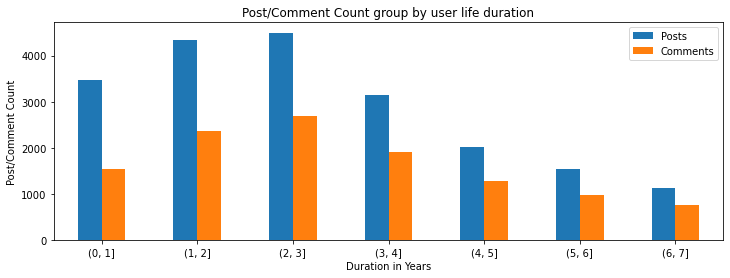

In [9]:
files_df['Users']['CreationDate'] = pd.to_datetime(files_df['Users']['CreationDate'])
now = datetime.datetime.now()
currentTimeInYears = float(now.year + pd.Series(now).dt.dayofyear/365)
files_df['Users']['CreationDuration']  = currentTimeInYears - (files_df['Users']['CreationDate'].dt.year + files_df['Users']['CreationDate'].dt.dayofyear/365)
top_100_user_post = top_users(files_df, 'PostHistory')
top_100_user_post = top_100_user_post.sort_values(by=['Count'], ascending = False)

top_100_user_comment = top_users(files_df, 'Comments')
top_100_user_comment = top_100_user_comment.sort_values(by=['Count'], ascending = False)


bins = pd.cut(top_100_user_post['CreationDuration'], np.arange(8))
number_of_post_count_per_duration = top_100_user_post.groupby(bins)['CreationDuration'].agg(['count']).rename(columns={'count':'Posts'})
bins = pd.cut(top_100_user_comment['CreationDuration'], np.arange(8))
number_of_comment_count_per_duration = top_100_user_comment.groupby(bins)['CreationDuration'].agg(['count']).rename(columns={'count':'Comments'})
posts_comments_creation_duration_counts = pd.concat([number_of_post_count_per_duration, number_of_comment_count_per_duration], axis=1)
posts_comments_creation_duration_counts

posts_comments_creation_duration_counts.plot(kind="bar", figsize = (12,4))
plt.ylabel("Post/Comment Count")
plt.xlabel("Duration in Years")
plt.title("Post/Comment Count group by user life duration")
plt.xticks(rotation=0)
plt.savefig('../plots/post-comment-count-group-by-user-creation-date', dpi=150, pad_inches = 0.3, bbox_inches='tight')
plt.show()